# 📘 **Emotion Detector**

## **Problem Definition**
The goal of this project is to build a machine learning-based text classifier that can **detect and categorize user emotions** from written input. The classifier identifies **seven emotions**:  
- Sadness  
- Anger  
- Anxiety  
- Hope  
- Confusion  
- Joy  
- Guilt  

## **Data**
The dataset contains textual sentences labeled with one of the seven target emotions.  
- **Source:** Sentences were manually created to cover all seven emotions. Additional examples were collected from reliable sources to increase diversity.    
- **Preprocessing:** Text is lowercased, punctuation and numbers are removed, and tokenized for modeling.  
- **Splits:** Data is divided into **Train (70%)**, **Validation (15%)**, and **Test (15%)** sets to ensure proper evaluation.

## **Features**
- **Text Features:** Raw text input converted to numerical representations using:
  - TF-IDF vectorization
  - Pretrained embeddings (Sentence-BERT / SBERT)
- **Labels:** Encoded integers representing the seven emotions.


## **Evaluation**
- **Hyperparameter Tuning:** The model is tuned using GridSearchCV on the training set to find the best hyperparameters for each classifier. The validation set is used to evaluate the performance of each configuration without touching the test set.

- **Model Testing:** After tuning, the best model is evaluated on the validation set first to check generalization. Once satisfied, the test set is used for final unbiased evaluation.

- **Metrics:**
  - Accuracy – Overall correctness (goal ≥ 90%)
  - Classification Report – Precision, recall, and F1-score for each emotion
  - Confusion Matrix – Shows which emotions are commonly misclassified

- **Models Tested:**
  - Support Vector Machine (SVM)
  - Logistic Regression
  - Multinomial Naive Bayes
  - Random Forest

In [ ]:
!pip install transformers --quiet
!pip install torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00


In [ ]:
# General imports
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
import joblib
import nbformat

# Scikit-learn imports for model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

# Transformers and sentence embeddings
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving old_emotion_dataset.csv to old_emotion_dataset.csv


In [ ]:
def train_and_evaluate_models(csv_path, text_col='text', label_col='label'):
    # Preprocess Text Function
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}0-9]", " ", text)
        tokens = text.split()
        return " ".join(tokens)

    # Load dataset
    df = pd.read_csv(csv_path)

    # Clean text
    df['clean_text'] = df[text_col].apply(preprocess_text)

    # Encode labels
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df[label_col])

    X = df['clean_text']
    y = df['label_encoded']

    # Split into Train, Validation, Test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

    # Define Classifiers
    classifiers = {
        "SVM": SVC(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Multinomial Naive Bayes": MultinomialNB(),
        "Random Forest": RandomForestClassifier(n_estimators=100)
    }

    # Train, Evaluate, and Print Confusion Matrix
    for name, clf in classifiers.items():
        print(f"\n\nTesting: {name}")

        # Build pipeline
        model = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
            ('clf', clf)
        ])

        # Train
        model.fit(X_train, y_train)

        # Predict on validation set
        y_val_pred = model.predict(X_val)

        # Classification Report
        print(f"\nClassification Report for {name} (Validation Set):\n")
        print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

        # Confusion Matrix
        cm = confusion_matrix(y_val, y_val_pred)
        print(f"{name} - Confusion Matrix (Validation):\n")
        print(cm)

In [ ]:
train_and_evaluate_models("old_emotion_dataset.csv")

Training samples: 373, Validation samples: 80, Test samples: 81


Testing: SVM

Classification Report for SVM (Validation Set):

              precision    recall  f1-score   support

       anger       1.00      0.42      0.59        12
     anxiety       0.80      0.31      0.44        13
        calm       0.91      0.83      0.87        12
        fear       0.75      0.50      0.60        12
   happiness       0.75      0.23      0.35        13
     sadness       0.38      1.00      0.55        18

    accuracy                           0.57        80
   macro avg       0.77      0.55      0.57        80
weighted avg       0.74      0.57      0.56        80

SVM - Confusion Matrix (Validation):

[[ 5  0  0  0  0  7]
 [ 0  4  0  2  0  7]
 [ 0  0 10  0  1  1]
 [ 0  1  0  6  0  5]
 [ 0  0  1  0  3  9]
 [ 0  0  0  0  0 18]]


Testing: Logistic Regression

Classification Report for Logistic Regression (Validation Set):

              precision    recall  f1-score   support

       ange

### **Next Step: Refining and Enhancing the Dataset**

After evaluating the performance of multiple models, it appears that the primary limitation lies in the quality and structure of the dataset, rather than in the models themselves. The validation results indicate that while some models perform moderately well like Logistic Regression with 66% accuracy, none are close to the 90% accuracy target. Misclassifications are particularly common in emotions like happiness, anxiety, and anger, suggesting that the dataset may not sufficiently capture the diversity and nuance of each emotional category. As a result, the next logical step is to conduct a manual review and refinement of the text data, following a text-focused Exploratory Data Analysis (EDA) approach.

**Rationale for Dataset Refinement**
1. Lack of Distinctive Language
  - Certain categories may lack strong, emotion-specific linguistic cues, reducing the model’s ability to learn clear distinctions between emotions.

3. Ambiguous or Generic Sentences
  - Some entries in the dataset may be too vague or non-specific, which makes it unclear which emotion is being expressed and weakens the training signal.

4. Incorrect or Overlapping Labels
  - There may be instances where sentences are labeled with the wrong emotion or express more than one emotional state, leading to confusion during training.

**Plan for Data Improvement**
  - Manually review each sentence across all emotion categories.
  - Verify that each sentence clearly reflects the labeled emotion without ambiguity.
  - Edit or remove sentences that could be interpreted as belonging to multiple categories.
  - Minimize overlapping language across different emotion classes, unless the context clearly distinguishes the usage.
  - Supplement the dataset with new, high-quality examples that better represent each emotion and enhance class distinction.

In [ ]:
# Refined Dataset

sadness = [
    # Loss
    "I ache when I remember they are gone",
    "The silence they left behind feels unbearable",
    "Memories of them make my chest feel heavy",
    "I cannot stop thinking about how much I miss them",
    "I feel like a part of me died with them",
    "Their absence leaves an empty space in my days",
    "Holidays feel hollow without them",
    "I find myself staring at their old belongings",
    "I feel a dull pain whenever I think of them",
    "I long for just one more conversation",
    "The world feels colder without them",
    "I keep imagining them walking through the door",
    "Every song reminds me of them",
    "I feel adrift without their presence",
    "I miss the way they made me feel safe",
    "I cannot imagine life without their guidance",
    "It hurts knowing I cannot see them again",
    "I cry quietly when no one is watching",
    "I wish time could rewind to when they were here",
    "I feel a deep void inside me every day",

    # Failure
    "My hard work ended in disappointment",
    "I keep reliving the moment I failed",
    "I feel crushed when my efforts lead nowhere",
    "I cannot shake the feeling of falling short",
    "It hurts when I try but still cannot succeed",
    "I feel like my dreams keep slipping away",
    "I watch others succeed while I stand still",
    "I question if I will ever achieve anything",
    "Every setback makes me feel smaller",
    "I feel undeserving when I cannot deliver",
    "I hate letting people down",
    "My failures weigh on me every day",
    "I feel embarrassed by my repeated mistakes",
    "I wish I could erase my failures",
    "I feel useless when I cannot do things right",
    "I compare myself and feel inadequate",
    "I feel left behind in life’s race",
    "I work hard but see no reward",
    "I fear I will always be a disappointment",
    "I feel defeated by my own efforts",

    # Loneliness
    "I spend most days in silence",
    "I feel invisible to the people around me",
    "My phone never rings anymore",
    "I long for someone to notice me",
    "Even in a crowd, I feel alone",
    "I miss having real conversations",
    "I feel like no one truly sees who I am",
    "I wish I had someone to share my day with",
    "I go places alone and come back alone",
    "My loneliness feels endless",
    "I crave companionship but cannot find it",
    "I feel like a ghost in my own home",
    "I miss hearing someone call my name with warmth",
    "The evenings feel especially empty",
    "I have no one to share my thoughts with",
    "I feel detached from everyone I know",
    "I keep my feelings to myself because no one asks",
    "I wish I could be part of something",
    "I feel forgotten by the world",
    "My days blend together in quiet isolation",

    # Rejection
    "Being ignored makes me feel worthless",
    "I feel discarded like I never mattered",
    "I gave my trust and it was thrown away",
    "I feel pushed aside without explanation",
    "I get replaced so easily by others",
    "I feel shut out from the people I care about",
    "I feel like I am always the last choice",
    "They turned their back on me when I needed them",
    "I feel like no one chooses me",
    "I keep wondering why I was not good enough",
    "I feel like my love was unreturned",
    "I was left behind while others moved forward",
    "I feel unwanted no matter what I do",
    "I am easily forgotten by people I care about",
    "It hurts when they leave without warning",
    "I feel disposable in people’s lives",
    "They chose to walk away from me",
    "I feel like my presence does not matter",
    "I was excluded without a reason",
    "I feel like I will always be left out",

    # Emotionally overwhelmed
    "I feel heavy-hearted for no clear reason",
    "My sadness follows me everywhere I go",
    "I wake up with a weight in my chest",
    "I am exhausted from feeling this way",
    "I carry a quiet pain all day",
    "Even happy moments feel tinted with sorrow",
    "I feel too tired to pretend I am okay",
    "My emotions drain all my energy",
    "I am drowning in a sea of feelings",
    "I feel broken in ways I cannot explain",
    "I struggle to hold back tears daily",
    "I wish I could shut off my emotions",
    "I feel emotionally fragile",
    "I am stuck in a cloud of sadness",
    "I carry pain that others cannot see",
    "I feel my heart aching constantly",
    "I am overwhelmed by my own thoughts",
    "I feel trapped in my sadness",
    "I cannot find the light in my days",
    "I feel like I am collapsing inside"
]

anxiety = [
    # Fear of future
    "I am scared that something bad will happen tomorrow",
    "I cannot stop worrying about what is coming next",
    "The thought of the future makes my chest feel tight",
    "I get nervous thinking about my plans not working out",
    "I fear everything might go wrong soon",
    "The uncertainty of life makes me feel uneasy",
    "I am worried that I will not achieve my goals",
    "The idea of change makes me panic",
    "I feel tense when I think about upcoming events",
    "I dread the next big step I have to take",
    "I am afraid I will not be ready for what is ahead",
    "I keep imagining worst-case scenarios",
    "I am nervous about starting something new",
    "I worry that my choices will ruin my future",
    "I feel uneasy not knowing what will happen",
    "I am scared of losing what I have built",
    "I stress about what the next year will bring",
    "I am anxious about the unknown ahead",
    "I feel a knot in my stomach about tomorrow",
    "I cannot relax when I think about the future",

    # Social anxiety
    "I panic when I have to talk to strangers",
    "I worry about embarrassing myself in public",
    "I feel tense when I am the center of attention",
    "I am scared people will judge me for what I say",
    "I avoid gatherings because I get too nervous",
    "I get shaky when I have to speak in front of a group",
    "I stress over making small talk",
    "I feel like people are silently criticizing me",
    "I am afraid I will say something wrong",
    "I feel my heartbeat speed up in social settings",
    "I avoid eye contact to hide my nervousness",
    "I am scared of being laughed at",
    "I overthink how I am being perceived",
    "I dread meeting new people",
    "I get nervous before walking into a room",
    "I am afraid people will not like me",
    "I avoid situations where I have to speak up",
    "I feel uncomfortable when people focus on me",
    "I feel pressure to act perfect in social situations",
    "I am scared of being judged by others",

    # Performance anxiety
    "I feel sick before any important performance",
    "I panic at the thought of presenting my work",
    "I worry that I will freeze in front of everyone",
    "I get tense when I know people are watching me",
    "I am scared of making mistakes under pressure",
    "I stress over every detail before a big test",
    "I feel nervous before stepping on stage",
    "I dread being evaluated by others",
    "I feel my palms sweat during important moments",
    "I fear that my mind will go blank",
    "I get shaky hands before important tasks",
    "I worry I am not good enough to succeed",
    "I am afraid of public failure",
    "I cannot sleep the night before a big event",
    "I stress about delivering a perfect result",
    "I am scared of disappointing people",
    "I feel intense pressure before deadlines",
    "I get stomach aches before presentations",
    "I am afraid I will not perform well enough",
    "I feel frozen under high expectations",

    # Health anxiety
    "I panic over every small ache or pain",
    "I fear I might have a hidden illness",
    "I cannot stop worrying about my health",
    "I get nervous before any medical check-up",
    "I am scared of catching a disease",
    "I overthink every symptom I feel",
    "I stress about my body not functioning properly",
    "I am worried I will get sick suddenly",
    "I feel tense after reading about illnesses",
    "I am afraid my health will get worse",
    "I dread visiting the doctor",
    "I constantly check my body for signs of sickness",
    "I am scared of health problems I cannot control",
    "I panic when I feel something unusual in my body",
    "I am afraid I will miss an early warning sign",
    "I stress about infections and germs",
    "I am uneasy in crowded places because of illness risk",
    "I cannot stop thinking about possible diseases",
    "I fear something serious is wrong with me",
    "I am anxious about staying healthy",

    # Generalized worry
    "I worry about things even when they are fine",
    "I cannot relax because I am always tense",
    "I stress over small problems too much",
    "I get nervous without knowing why",
    "I fear the worst in every situation",
    "I feel on edge most of the day",
    "I keep imagining bad things happening",
    "I am anxious even when nothing is wrong",
    "I get tense over tiny mistakes",
    "I cannot stop worrying about everything",
    "I feel uneasy without a clear reason",
    "I stress about losing control",
    "I feel restless most of the time",
    "I overthink every decision I make",
    "I feel dread when I have free time",
    "I get nervous just thinking about my to-do list",
    "I am worried something will go wrong soon",
    "I cannot calm my mind when I try to relax",
    "I feel pressure even in simple tasks",
    "I stay tense from morning to night"
]

anger = [
    # Frustration
    "I am tired of everything right now",
    "Small things are making me upset",
    "I feel stressed and tense all the time",
    "Why is everything so hard",
    "Things are moving too slow and it annoys me",
    "I hate being ignored",
    "Even little problems are bothering me",
    "Things are not going how I hoped",
    "This situation is testing my patience",
    "Waiting is making me frustrated",
    "I feel like I might snap any moment",
    "I keep saying the same thing and no one listens",
    "I deal with the same issues every day and I am tired",
    "Nothing is going right and I feel stressed",
    "Even small sounds are annoying me today",
    "I am on edge and ready to lose it",
    "People keep wasting my time and it frustrates me",
    "I act like I am okay, but I am really upset",
    "I have no patience left",
    "I just want to scream and get it out",

    # Resentment
    "I did my best but still got ignored",
    "It hurts to see them win when I worked just as hard",
    "I still remember how badly they treated me",
    "I feel angry about how things ended",
    "No one notices what I do",
    "I am still mad at them deep down",
    "They took all the credit like I did nothing",
    "It still hurts that they moved on so fast",
    "I feel like they used me and left",
    "They always treat people badly and get away with it",
    "I pretend I am fine, but I am angry inside",
    "I gave a lot and got nothing back",
    "I cannot forget how they hurt me",
    "I feel more angry every time I think about it",
    "They never said sorry, and it still bothers me",
    "I do not think I can ever forgive them",
    "I feel like they pushed me aside",
    "It upsets me that they never said anything about how I felt",
    "I stayed loyal, but they let me down",
    "I try to move on, but I am still holding onto it",

    # Rage
    "I suddenly started yelling",
    "I was so mad I could not think straight",
    "I feel like I am about to lose control",
    "I slammed the door without thinking",
    "I screamed at them and did not care",
    "I got so angry I could not stop myself",
    "I was too angry to think clearly",
    "I wanted to break something just to let it out",
    "I hit the wall because I was so angry",
    "I was shaking I was so mad",
    "I lost it and started shouting",
    "I felt so angry I just snapped",
    "I got hit with a wave of anger I could not control",
    "I held it in too long and then I exploded",
    "I could not keep it in anymore and I lashed out",
    "Even I got scared of how angry I was",
    "I yelled without thinking and now I feel tired",
    "It felt like I was burning inside from anger",
    "I could not hold it in anymore",
    "I had a total meltdown from the anger",

    # Injustice
    "It is not fair how they were treated",
    "I cannot believe they let this happen",
    "Why do bad people always get their way",
    "I am angry about all the unfair things I see",
    "This makes me lose hope in people",
    "They did not care about her pain at all",
    "I cannot stay quiet about this anymore",
    "What they did was cruel and wrong",
    "No one is being blamed for what happened",
    "They keep getting away with hurting others",
    "The system feels broken and unfair",
    "Everyone should be mad about this kind of thing",
    "I am really upset by what I saw today",
    "It hurts to see people treated badly",
    "I am filled with anger over what they did",
    "They try to shut up the people telling the truth",
    "I am mad because no one is trying to fix it",
    "I do not understand how they can ignore this",
    "What happened is wrong and I will not act like it is okay",
    "This is a clear abuse of power and it makes me furious",

    # Passive aggression
    "I feel like I am done trying",
    "I say I am fine, but I am really not",
    "They do whatever they want, and I just let it happen now",
    "I stopped texting back because no one listens to me",
    "I feel like they do not care about how I feel",
    "My opinion does not seem to matter to them",
    "I pretend I am okay, but I am not",
    "I am not mad, just really let down",
    "They only talk to me when they need something",
    "I feel like I am always left out",
    "I stay away now because I am tired of the drama",
    "I stay quiet because arguing does not help",
    "I act chill, but inside I am upset",
    "I feel invisible sometimes",
    "I stopped trying because it feels useless",
    "They always decide without asking me",
    "They never think about how I feel",
    "Explaining myself never works anyway",
    "I feel like I always have to be the one to back down",
    "It feels like they just do not care"
]

guilt = [
    # Personal responsibility and regret
    "I take full responsibility for my mistakes.",
    "I regret the wrong things I have done.",
    "I feel remorse for my bad actions.",
    "I wish I could undo my past faults.",
    "I feel ashamed for not doing what is right.",
    "I am sorry for the harm I caused others.",
    "I acknowledge my sins and want to change.",
    "I feel accountable for my actions.",
    "I regret hurting the people I love.",
    "I want to correct my mistakes sincerely.",
    "I feel guilty for my selfish behavior.",
    "I am working on being a better person.",
    "I am sorry for disappointing those I care about.",
    "I feel burdened by my wrongdoings.",
    "I want to fix what I have broken.",
    "I wish I had been more honest.",
    "I feel heavy with guilt for my mistakes.",
    "I am sorry for the times I lied.",
    "I regret betraying someone's trust.",
    "I want to make amends for my past errors.",
    "I feel remorse for breaking my promises.",
    "I ask Allah to help me change my ways.",
    "I want to avoid repeating my sins.",
    "I feel bad for my wrong intentions.",
    "I pray for strength to overcome my faults.",
    "I feel the weight of my guilt deeply.",
    "I want to be forgiven for my past mistakes.",
    "I am sorry for the times I was careless.",
    "I want to live honestly from now on.",
    "I regret not being kinder when I had the chance.",

    # Moral and religious accountability
    "I feel guilty for neglecting my prayers.",
    "I ask Allah to forgive me for my sins.",
    "I want to repent sincerely for my wrongs.",
    "I feel shame for not following Islamic teachings.",
    "I regret missing important religious duties.",
    "I pray to be closer to Allah every day.",
    "I want to purify my heart from bad deeds.",
    "I am sorry for breaking the rules of my faith.",
    "I want to strengthen my relationship with Allah.",
    "I ask for Allah’s mercy on my soul.",
    "I want to follow the Prophet’s example better.",
    "I feel bad for neglecting the Quran.",
    "I want to stay away from sinful actions.",
    "I pray for guidance to the right path.",
    "I am sorry for losing focus on my faith.",
    "I want to improve my worship and obedience.",
    "I feel guilty for falling into bad habits.",
    "I want to make my faith stronger every day.",
    "I ask Allah to guide me away from wrongdoing.",
    "I want to be humble and patient in my religion.",
    "I feel ashamed for missing my prayers on purpose.",
    "I pray to be forgiven and to live righteously.",
    "I want to honor Allah in all I do.",
    "I regret ignoring the reminders of my religion.",
    "I want to seek Allah’s forgiveness daily.",
    "I feel guilty for forgetting to thank Allah.",
    "I want to improve my character through faith.",
    "I ask Allah to keep me on the straight path.",
    "I want to avoid anything that displeases Allah.",
    "I feel remorse for wasting my time away from Allah.",

    # Relationship guilt
    "I feel guilty for hurting my family members.",
    "I want to apologize to those I have wronged.",
    "I regret being unkind to my parents.",
    "I want to make peace with my loved ones.",
    "I feel sorry for causing pain to my friends.",
    "I want to rebuild trust with my family.",
    "I feel guilty for neglecting my relatives.",
    "I pray to Allah to soften my heart towards others.",
    "I want to treat my family with more respect.",
    "I feel bad for breaking important promises to friends.",
    "I want to forgive and ask for forgiveness in return.",
    "I feel sorry for my harsh words in anger.",
    "I want to show more patience to my siblings.",
    "I regret not supporting my loved ones better.",
    "I want to be kinder and more understanding.",
    "I ask Allah to heal the wounds I have caused.",
    "I want to be a source of love and kindness at home.",
    "I feel guilty for not spending enough time with family.",
    "I pray for the strength to mend broken relationships.",
    "I want to avoid hurting others with my actions.",
    "I feel ashamed for ignoring my family’s feelings.",
    "I want to be gentle and forgiving to those around me.",
    "I regret being careless with other people's hearts.",
    "I want to make things right before it is too late.",
    "I ask Allah to guide me to be a better family member.",
    "I want to live peacefully with those I love.",
    "I feel bad for putting my needs before others.",
    "I want to build stronger bonds with my friends.",
    "I pray for forgiveness from those I have hurt.",
    "I want to honor my parents with my actions.",

    # Desire to improve and make amends
    "I want to change and become a better person.",
    "I pray for help to fix my mistakes.",
    "I want to live according to Allah’s will.",
    "I ask Allah to guide my heart to goodness.",
    "I want to leave my bad habits behind.",
    "I seek to be honest and truthful in all things.",
    "I want to forgive myself and move forward.",
    "I want to serve others with kindness and love.",
    "I pray for strength to resist temptation.",
    "I want to rebuild my character with patience.",
    "I ask Allah to help me avoid sinning again.",
    "I want to grow spiritually every day.",
    "I want to make peace with my past mistakes.",
    "I want to be humble and grateful for Allah’s mercy.",
    "I want to show compassion to everyone I meet.",
    "I pray for a heart full of faith and forgiveness.",
    "I want to act with kindness, not anger.",
    "I ask Allah to heal my soul and guide my steps.",
    "I want to follow the path of goodness and mercy.",
    "I want to be a better Muslim for Allah’s sake."
]

joy = [
    # Gratitude
    "I am so thankful to Allah for all my blessings",
    "Alhamdulillah, I have peace in my heart today",
    "I feel blessed and grateful for my family",
    "Thank Allah for giving me strength through hard times",
    "I am thankful for the health I have been given",
    "I praise Allah for the small joys in life",
    "I feel grateful every day for Allah’s mercy",
    "Alhamdulillah, I have food and shelter today",
    "I thank Allah for protecting me and my loved ones",
    "I am grateful for the forgiveness Allah shows me",
    "Thank Allah for the chance to improve myself",
    "I feel blessed to be guided on the right path",
    "I thank Allah for the kindness of others",
    "Alhamdulillah, I am grateful for every new day",
    "I feel thankful for the Quran’s guidance",
    "I appreciate Allah’s blessings even in tough times",
    "Thank Allah for the peace in my heart",
    "I am grateful for the prayers answered",
    "Alhamdulillah, I have friends who support me",
    "I thank Allah for giving me hope and patience",

    # Contentment
    "I feel calm because I know Allah is in control",
    "My heart is peaceful because of my faith",
    "I am happy with what Allah has given me",
    "I feel comfort when I trust Allah’s plan",
    "My heart feels calm because of Allah’s mercy",
    "I stay calm even when life is hard",
    "I trust Allah’s timing and feel peaceful",
    "I am thankful for the blessings I have",
    "My faith helps me feel calm in every situation",
    "I am happy and thankful for today",
    "I feel peaceful after praying and asking Allah",
    "I trust Allah and feel calm inside",
    "My soul feels rested because of my faith",
    "I am happy with what Allah gives me",
    "I feel calm because Allah is always near",
    "I find peace when I read the Quran",
    "My heart is quiet because I trust Allah",
    "I am thankful and happy for Allah’s gifts",
    "I feel calm even when things are not clear",
    "My faith helps me stay peaceful during hard times"

    # Excitement
    "I am happy about the new chances Allah gave me",
    "I feel good and ready to start the day",
    "Alhamdulillah, I am ready for new challenges",
    "I am thankful and happy for Allah’s blessings",
    "I look forward to getting closer to Allah",
    "I want to learn more about my faith",
    "I am excited to help people who need it",
    "I am thankful for the chance to improve myself",
    "I feel happy to share Allah’s mercy with others",
    "I have lots of energy to do good things",
    "I am excited for the next Ramadan",
    "Alhamdulillah, I feel hopeful about what is coming",
    "I am excited to pray and feel close to Allah",
    "I feel happy thinking about Allah’s blessings",
    "I want to study Quran more",
    "I feel happy and motivated to do better",
    "I am excited to meet my community",
    "Alhamdulillah, I have energy to worship today",
    "I feel alive and thankful for Allah’s guidance",
    "I am excited to make good changes in my life",

    # Pride
    "I feel good that I stayed patient",
    "Alhamdulillah, I worked hard and did well",
    "I am happy with how my faith is growing",
    "I feel proud to follow Allah’s way",
    "I thank Allah for helping me reach my goals",
    "I feel proud for being kind to others",
    "I am happy I kept my promises to Allah",
    "I feel proud for praying better",
    "Alhamdulillah, I faced problems and stayed strong with faith",
    "I feel proud to be a good example for others",
    "I feel happy doing good things",
    "I thank Allah for giving me strength to keep going",
    "I feel proud of the changes I made in my life",
    "I am happy Allah trusts me",
    "I feel proud for being patient during hard times",
    "Alhamdulillah, I feel sure about my faith",
    "I feel proud for forgiving others like Allah teaches",
    "I feel happy when I help others",
    "I thank Allah for guiding me",
    "I feel proud to keep learning and growing",

    # Love
    "I feel happy spending time with my family",
    "Alhamdulillah, I have love and support around me",
    "I feel lucky to have caring friends",
    "I thank Allah for the love in my heart",
    "I feel close to Allah when I pray",
    "I am thankful for my parents’ love and help",
    "I feel happy when I help my neighbors",
    "I am glad to be kind to others",
    "I feel connected to my community through faith",
    "Alhamdulillah, I have people who care about me",
    "I feel love grow when I read the Quran",
    "I am thankful for calm moments with my loved ones",
    "I feel happy when I forgive and get forgiveness",
    "I feel close to Allah when I make dua",
    "I smile when I see others happy",
    "I thank Allah for my family bonds",
    "I feel love when I do good for others",
    "I am grateful for the friends Allah gave me",
    "I feel peace being part of the Muslim community",
    "Alhamdulillah, love fills my heart today"
]

hope = [
    # Optimism
    "I believe good things will happen soon",
    "I am hopeful for a better tomorrow",
    "Alhamdulillah, I trust that Allah has good plans for me",
    "I feel positive about what the future holds",
    "I am confident that things will get easier",
    "I look forward to better days ahead",
    "I believe Allah will guide me through hard times",
    "I feel hopeful even when things are hard",
    "I trust that the future will bring happiness",
    "I know Allah’s mercy is greater than my worries",
    "I am excited about new opportunities coming",
    "I believe Allah will help me reach my goals",
    "I feel positive about the next steps in my life",
    "I trust that Allah’s plan is the best for me",
    "I am hopeful for blessings that are yet to come",
    "I believe I will overcome my struggles",
    "I look forward to Allah’s mercy every day",
    "I feel sure that Allah will open new doors",
    "I am hopeful and trust Allah’s timing",
    "I believe good will come from patience and faith",

    # Faith in Allah's mercy and help
    "I trust Allah will forgive me and help me",
    "Alhamdulillah, Allah’s mercy is always with me",
    "I believe Allah listens to my prayers",
    "I know Allah will guide me through my problems",
    "I have faith that Allah will make things better",
    "I feel comfort knowing Allah is merciful",
    "I believe Allah will protect me from harm",
    "I trust Allah’s help when I am in trouble",
    "I feel peace knowing Allah is watching over me",
    "I believe Allah’s mercy is endless",
    "I trust Allah will answer my duas in the best way",
    "I have faith Allah will never abandon me",
    "I feel hopeful because Allah is forgiving",
    "I believe Allah’s help is near when I am patient",
    "Alhamdulillah, I feel blessed by Allah’s kindness",
    "I trust Allah will guide me to the right path",
    "I believe Allah’s mercy covers all my mistakes",
    "I feel comforted by Allah’s promises in the Quran",
    "I trust Allah will help me find peace",
    "I believe Allah is always ready to forgive",

    # Patience
    "I am trying to be patient during hard times",
    "I believe Allah rewards those who are patient",
    "Alhamdulillah, I keep trusting Allah while waiting",
    "I know good things come to those who wait",
    "I am hopeful even when things take time",
    "I keep praying and stay patient",
    "I believe Allah will make things easier soon",
    "I am strong because I trust Allah’s plan",
    "I know Allah is testing me for a reason",
    "I stay calm and hopeful through struggles",
    "I believe patience will bring me closer to Allah",
    "I keep my faith strong while waiting for answers",
    "Alhamdulillah, patience helps me grow",
    "I am hopeful that my hard work will pay off",
    "I trust Allah’s timing, even if it is slow",
    "I am learning to be patient and thankful",
    "I believe every difficulty has a blessing",
    "I stay hopeful and keep praying every day",
    "I know Allah sees my patience and will reward me",
    "I believe good will come after hardship",

    # Desire for personal goals
    "I want to be a better Muslim every day",
    "I hope to improve my prayers and faith",
    "Alhamdulillah, I am working on being kinder",
    "I want to learn more about Islam",
    "I hope Allah helps me change for the better",
    "I want to control my anger and be patient",
    "I am trying to be more honest and humble",
    "I hope to read Quran more regularly",
    "I want to help others like Allah teaches",
    "I am thankful for chances to improve myself",
    "I want to be more grateful for Allah’s blessings",
    "I am working on forgiving others and myself",
    "I hope to be more thankful and content",
    "I want to grow closer to Allah every day",
    "I am trying to follow the Sunnah more",
    "I want to stop bad habits and start good ones",
    "I hope Allah makes my heart soft and kind",
    "I want to be more patient and trusting",
    "I am thankful for Allah’s guidance to improve",
    "I hope to be a better person in the eyes of Allah",

    # Expectation of relief or success
    "I hope Allah eases my problems soon",
    "I believe my prayers for help will be answered",
    "Alhamdulillah, I am waiting for good news",
    "I trust Allah will bring relief after hardship",
    "I feel hopeful that my difficulties will end",
    "I expect Allah’s mercy to help me heal",
    "I am praying for success in my work and life",
    "I hope Allah makes my future bright",
    "I believe relief will come if I keep faith",
    "I am hopeful that Allah will answer my duas",
    "I expect good things after this hard time",
    "I trust Allah to make my way easy",
    "I am waiting patiently for Allah’s help",
    "I believe my efforts will bring success with Allah’s help",
    "I hope Allah removes my worries soon",
    "I expect Allah to bless my efforts",
    "I am hopeful Allah will guide me to success",
    "I trust Allah will give me strength to overcome",
    "I am praying for peace and relief in my heart",
    "I believe Allah’s help will come at the right time"
]

confusion = [
    # Misunderstanding instructions
    "I read the steps twice and they still do not make sense",
    "I cannot tell if I am supposed to turn left or right",
    "The directions are written in a way I cannot follow",
    "I feel lost trying to follow these instructions",
    "I am not sure which button I am supposed to click",
    "The manual says one thing but the screen shows another",
    "I cannot figure out what the teacher is asking for",
    "I keep reading but the words do not connect in my head",
    "I cannot match what they are saying to what I see",
    "I feel like the steps are out of order",
    "The labels do not match the instructions I was given",
    "I cannot tell which tool I should use first",
    "I keep mixing up the sequence of steps",
    "I do not know what this symbol is supposed to mean",
    "The instructions feel incomplete to me",
    "I have to guess what comes next because it is unclear",
    "I am stuck because the guide is too vague",
    "I cannot figure out which part is being described",
    "The explanation feels contradictory",
    "I feel like I am missing an important step",

    # Unclear memory
    "I cannot remember if I locked the door or not",
    "I feel like I forgot something important but I do not know what",
    "I cannot recall where I put my phone",
    "I was about to say something but forgot mid-sentence",
    "I am trying to remember the name but it will not come to me",
    "I know I learned this before but it feels new",
    "I cannot remember which day the event is on",
    "I keep forgetting small details lately",
    "I feel like my memory is foggy right now",
    "I cannot remember the last step in the process",
    "I was going somewhere but forgot why",
    "I keep mixing up names of people",
    "I am not sure if I told them already or not",
    "I cannot recall what I was doing five minutes ago",
    "I feel like my brain skipped a part of the conversation",
    "I cannot remember the exact number I just read",
    "I keep asking the same question because I forget the answer",
    "I am not sure if I left something on at home",
    "I forgot the main point of the story I was telling",
    "I cannot remember which file I saved it in",

    # Conflicting information
    "They told me two different answers and I do not know which is right",
    "One source says yes and another says no",
    "I get different instructions from different people",
    "The numbers do not match between reports",
    "I cannot decide because the data is conflicting",
    "One person says to go fast, another says to go slow",
    "The rules seem to change depending on who I ask",
    "I was told both options are correct, which is confusing",
    "The chart says one thing but the text says another",
    "I cannot match the figures between the two lists",
    "They gave me opposite instructions in the same meeting",
    "I see two versions of the same information",
    "The signs point in different directions",
    "One page says it is allowed, the other says it is not",
    "The results are completely opposite in two reports",
    "I cannot reconcile the two explanations",
    "It feels like the guidelines contradict each other",
    "They told me to start and stop at the same time",
    "Two documents give different definitions for the same term",
    "I am not sure which source is trustworthy",

    # Disorientation
    "I do not know where I am in this building",
    "I feel turned around and cannot find the exit",
    "I walked in a circle without realizing",
    "I do not remember which floor I came from",
    "I feel lost trying to find the right classroom",
    "I cannot figure out which hallway leads where",
    "I am not sure which direction is north",
    "I feel like I am going the wrong way",
    "I got off the bus and have no idea where I am",
    "I cannot remember which door I used to come in",
    "I am unsure if I passed this street already",
    "I took a wrong turn and now I am lost",
    "I cannot find my way back to the main road",
    "I do not recognize the buildings around me",
    "I feel like the layout keeps changing",
    "I walked to the wrong place by mistake",
    "I am not sure which stop is mine",
    "I got confused between two similar streets",
    "I cannot find the place on the map",
    "I do not know where I ended up after walking",

    # Difficulty interpreting
    "I cannot understand what this diagram is showing",
    "The picture does not match the description",
    "I am not sure what the graph is trying to say",
    "I cannot tell what this symbol means",
    "The table is too messy for me to read",
    "I cannot figure out which line belongs to which label",
    "I feel like I am looking at a puzzle with missing pieces",
    "The chart looks upside down to me",
    "I am unsure how to read the numbers in this table",
    "I cannot tell if the image is before or after",
    "I do not know what these markings stand for",
    "The legend does not match the colors in the map",
    "I cannot connect the data points in my head",
    "I am not sure how this equation is supposed to work",
    "I feel like the diagram leaves out key details",
    "The information is jumbled together in my mind",
    "I cannot follow the logic in this example",
    "I am unsure what the highlighted part means",
    "I feel like I am missing the main point of this image",
    "I cannot figure out how this is supposed to fit together"
]

texts = sadness + anxiety + anger + guilt + joy + hope + confusion
labels = (
    ["sadness"] * len(sadness) +
    ["anxiety"] * len(anxiety) +
    ["anger"] * len(anger) +
    ["guilt"] * len(guilt) +
    ["joy"] * len(joy) +
    ["hope"] * len(hope) +
    ["confusion"] * len(confusion)
)

# Check for duplicate sentences

# Count total vs unique sentences
print(f"Total sentences: {len(texts)}")
print(f"Unique sentences: {len(set(texts))}")

# Find duplicates
from collections import Counter

text_counts = Counter(texts)
duplicates = [text for text, count in text_counts.items() if count > 1]

print(f"Number of duplicate sentences: {len(duplicates)}")
print("Examples of duplicates:")
for dup in duplicates[:10]:  # Show first 10
    print("-", dup)

# Creating csv file of the dataset above

import pandas as pd

df = pd.DataFrame({
    'text': texts,
    'label': labels
})

# Save to CSV
df.to_csv('refined_emotion_dataset.csv', index=False)

Total sentences: 709
Unique sentences: 709
Number of duplicate sentences: 0
Examples of duplicates:


In [ ]:
train_and_evaluate_models("refined_emotion_dataset.csv")

Training samples: 496, Validation samples: 106, Test samples: 107


Testing: SVM

Classification Report for SVM (Validation Set):

              precision    recall  f1-score   support

       anger       0.82      0.93      0.88        15
     anxiety       0.93      0.93      0.93        15
   confusion       0.86      0.80      0.83        15
       guilt       0.84      1.00      0.91        16
        hope       0.86      0.80      0.83        15
         joy       0.83      0.67      0.74        15
     sadness       0.80      0.80      0.80        15

    accuracy                           0.85       106
   macro avg       0.85      0.85      0.85       106
weighted avg       0.85      0.85      0.85       106

SVM - Confusion Matrix (Validation):

[[14  0  0  0  0  0  1]
 [ 0 14  0  0  0  0  1]
 [ 2  0 12  0  0  0  1]
 [ 0  0  0 16  0  0  0]
 [ 0  1  0  0 12  2  0]
 [ 0  0  1  2  2 10  0]
 [ 1  0  1  1  0  0 12]]


Testing: Logistic Regression

Classification Report for Logisti

**Models Performance Analysis on Validation Set**

SVM
  - Accuracy: 85% on validation set, the highest among all models.
  - Strong performance on anger, anxiety, guilt, and moderate on joy, confusion.
  - Misclassifications mostly occur between confusion/joy and anger/sadness, which may indicate some lexical overlap in the dataset.

Logistic Regression
  - Accuracy: 81%, slightly lower than SVM.
  - Performs well on anger, anxiety, guilt.
  - Misclassifications mostly in confusion, hope, sadness, showing that linear boundaries may not capture some complex patterns.

Multinomial Naive Bayes
  - Accuracy: 84%, comparable to SVM.
  - Excels in categories like anger, guilt and anxiety that have more distinctive word distributions.
  - Struggles slightly with sadness and confusion, which may share vocabulary with other emotions.

Random Forest
  - Accuracy: 71%, lowest among models.
  - It varies a lot across different emotions, especially hope, which it only correctly identifies 47% of the time, and sadness, which it correctly identifies 73% of the time.
  - May indicate that ensemble trees are not capturing sequential or semantic patterns in textual data as effectively.

### **Next Step: Using Different Embeddings**

To improve model performance, I will retrain both the SVM and Logistic Regression models using advanced text embeddings, specifically BERT, SBERT, and variants of SBERT such as all MiniLM L6 v2 and all mpnet base v2. Unlike TFIDF, which simply counts word frequency, these transformer based embeddings capture the meaning of words in context, allowing models to better understand the actual content of the text and potentially achieve higher accuracy.

Since these embeddings produce dense, contextualized vectors rather than simple word counts, they are not compatible with the Multinomial Naive Bayes model. Therefore, I will continue using TFIDF for Naive Bayes but experiment with increasing the max features parameter. This will allow the model to consider a broader vocabulary, which may help it learn more useful patterns.

By comparing the performance of SVM and Logistic Regression using different contextual embeddings including BERT, SBERT, and its variants, I aim to evaluate how much semantic understanding contributes to improved classification results over traditional feature representations like TFIDF.

In [ ]:
def train_evaluate_naive_bayes(csv_path, text_col='text', label_col='label'):
    """
    Train and evaluate a Multinomial Naive Bayes classifier using TF-IDF features.
    Evaluates on validation and test sets. Returns trained pipeline + label encoder.
    """

    # Preprocess text
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}0-9]", " ", text)
        tokens = text.split()
        return " ".join(tokens)

    # Load dataset
    df = pd.read_csv(csv_path)

    # Clean text
    df['clean_text'] = df[text_col].apply(preprocess_text)

    # Encode labels
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df[label_col])

    X = df['clean_text']
    y = df['label_encoded']

    # Split Train / Validation / Test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

    # Build Naive Bayes Pipeline
    nb_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('clf', MultinomialNB(alpha=1.0))
    ])

    # Train
    nb_pipeline.fit(X_train, y_train)

    # Evaluate on Validation Set
    y_val_pred = nb_pipeline.predict(X_val)
    print("\nNaive Bayes Validation Performance (TF-IDF):")
    print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

    cm_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="coolwarm",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Naive Bayes - Confusion Matrix (Validation)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Evaluate on Test Set
    y_test_pred = nb_pipeline.predict(X_test)
    print("\nNaive Bayes Test Performance (TF-IDF):")
    print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="viridis",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Naive Bayes - Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Return model and encoder
    return nb_pipeline, label_encoder

Training samples: 496, Validation samples: 106, Test samples: 107

Naive Bayes Validation Performance (TF-IDF):
              precision    recall  f1-score   support

       anger       0.75      1.00      0.86        15
     anxiety       1.00      1.00      1.00        15
   confusion       0.85      0.73      0.79        15
       guilt       0.76      1.00      0.86        16
        hope       0.86      0.80      0.83        15
         joy       0.85      0.73      0.79        15
     sadness       0.90      0.60      0.72        15

    accuracy                           0.84       106
   macro avg       0.85      0.84      0.83       106
weighted avg       0.85      0.84      0.83       106



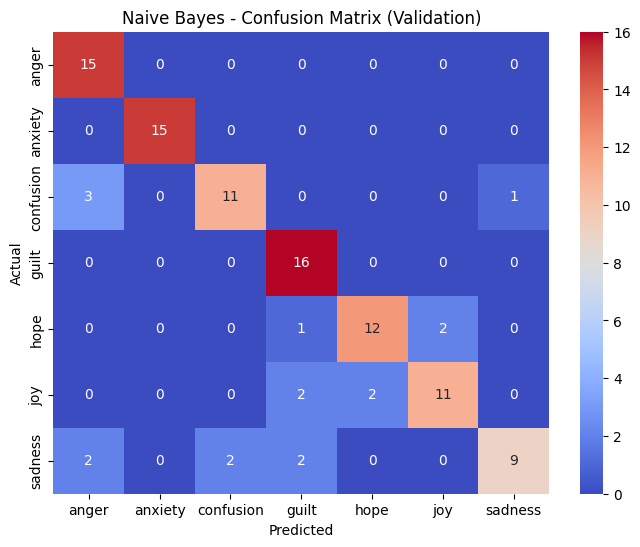


Naive Bayes Test Performance (TF-IDF):
              precision    recall  f1-score   support

       anger       0.58      0.73      0.65        15
     anxiety       1.00      0.80      0.89        15
   confusion       0.88      0.93      0.90        15
       guilt       0.71      1.00      0.83        17
        hope       0.83      0.67      0.74        15
         joy       0.74      0.93      0.82        15
     sadness       0.80      0.27      0.40        15

    accuracy                           0.77       107
   macro avg       0.79      0.76      0.75       107
weighted avg       0.79      0.77      0.75       107



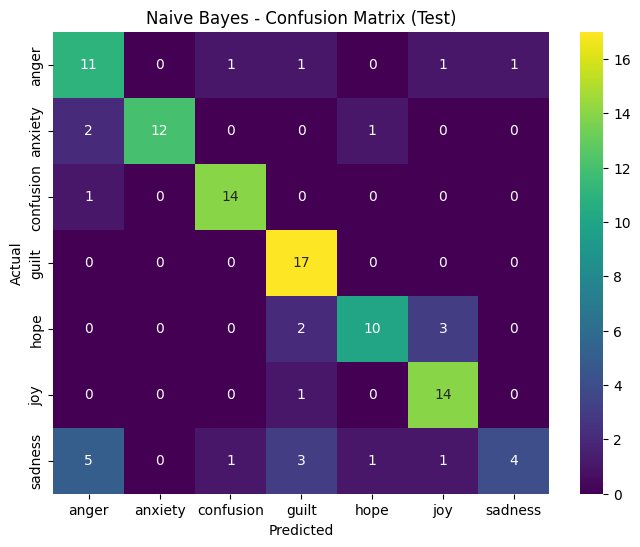

(Pipeline(steps=[('tfidf',
                  TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                 ('clf', MultinomialNB())]),
 LabelEncoder())

In [ ]:
train_evaluate_naive_bayes("refined_emotion_dataset.csv")

Naive Bayes is not performing well, even after increasing max_features, so I am going to drop it and focus on other models instead.



In [ ]:
def train_classifier(
    dataset_path,
    text_col='text',
    label_col='label',
    bert_model_name='all-mpnet-base-v2',
    model_type='svm'
):
    # Load dataset
    df = pd.read_csv(dataset_path)
    X = df[text_col].astype(str).values
    y = df[label_col].astype(str).values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split train / val / test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Encode with SBERT
    sbert_model = SentenceTransformer(bert_model_name)
    X_train_emb = sbert_model.encode(X_train.tolist(), batch_size=16, show_progress_bar=False)
    X_val_emb = sbert_model.encode(X_val.tolist(), batch_size=16, show_progress_bar=False)
    X_test_emb = sbert_model.encode(X_test.tolist(), batch_size=16, show_progress_bar=False)

    # Build pipeline
    if model_type == 'svm':
        classifier = SVC()
    elif model_type == 'logistic':
        classifier = LogisticRegression(max_iter=1000)
    else:
        raise ValueError("Unsupported model type. Choose 'svm' or 'logistic'.")

    pipeline = make_pipeline(StandardScaler(), classifier)

    # Train model
    pipeline.fit(X_train_emb, y_train)

    # Validation set evaluation
    y_val_pred = pipeline.predict(X_val_emb)
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

    cm_val = confusion_matrix(y_val, y_val_pred)
    print("\nConfusion Matrix (Validation Set):\n")
    print(cm_val)

    # Test set evaluation
    y_test_pred = pipeline.predict(X_test_emb)
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

    cm_test = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix (Test Set):\n")
    print(cm_test)

    return pipeline, label_encoder

In [ ]:
# bert-base-uncased embedding
train_classifier(
    dataset_path='refined_emotion_dataset.csv',
    text_col='text',
    label_col='label',
    bert_model_name='bert-base-uncased',
    model_type='svm'
)

# bert-base-nli-mean-tokens embedding
train_classifier(
    dataset_path='refined_emotion_dataset.csv',
    text_col='text',
    label_col='label',
    bert_model_name='bert-base-nli-mean-tokens',
    model_type='svm'
)

# all-mpnet-base-v2 embedding
train_classifier(
    dataset_path='refined_emotion_dataset.csv',
    text_col='text',
    label_col='label',
    bert_model_name='all-mpnet-base-v2',
    model_type='svm'
)

# all-MiniLM-L6-v2 embedding
train_classifier(
    dataset_path='refined_emotion_dataset.csv',
    text_col='text',
    label_col='label',
    bert_model_name='all-MiniLM-L6-v2',
    model_type='svm'
)

Train: 496, Val: 106, Test: 107


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Classification Report (Validation Set):
              precision    recall  f1-score   support

       anger       1.00      0.80      0.89        15
     anxiety       0.88      1.00      0.94        15
   confusion       1.00      0.93      0.97        15
       guilt       1.00      1.00      1.00        16
        hope       0.92      0.80      0.86        15
         joy       0.82      0.93      0.88        15
     sadness       0.88      1.00      0.94        15

    accuracy                           0.92       106
   macro avg       0.93      0.92      0.92       106
weighted avg       0.93      0.92      0.92       106


Confusion Matrix (Validation Set):

[[12  1  0  0  0  0  2]
 [ 0 15  0  0  0  0  0]
 [ 0  1 14  0  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 12  3  0]
 [ 0  0  0  0  1 14  0]
 [ 0  0  0  0  0  0 15]]

Classification Report (Test Set):
              precision    recall  f1-score   support

       anger       0.67      0.93      0.78        15
     anxiety

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Classification Report (Validation Set):
              precision    recall  f1-score   support

       anger       0.83      0.67      0.74        15
     anxiety       0.88      1.00      0.94        15
   confusion       1.00      0.93      0.97        15
       guilt       0.89      1.00      0.94        16
        hope       0.92      0.73      0.81        15
         joy       0.83      1.00      0.91        15
     sadness       0.73      0.73      0.73        15

    accuracy                           0.87       106
   macro avg       0.87      0.87      0.86       106
weighted avg       0.87      0.87      0.86       106


Confusion Matrix (Validation Set):

[[10  1  0  0  1  0  3]
 [ 0 15  0  0  0  0  0]
 [ 0  0 14  0  0  0  1]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  2 11  2  0]
 [ 0  0  0  0  0 15  0]
 [ 2  1  0  0  0  1 11]]

Classification Report (Test Set):
              precision    recall  f1-score   support

       anger       0.71      0.80      0.75        15
     anxiety

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Classification Report (Validation Set):
              precision    recall  f1-score   support

       anger       0.93      0.87      0.90        15
     anxiety       0.94      1.00      0.97        15
   confusion       1.00      1.00      1.00        15
       guilt       0.94      0.94      0.94        16
        hope       0.86      0.80      0.83        15
         joy       0.88      0.93      0.90        15
     sadness       0.93      0.93      0.93        15

    accuracy                           0.92       106
   macro avg       0.92      0.92      0.92       106
weighted avg       0.92      0.92      0.92       106


Confusion Matrix (Validation Set):

[[13  1  0  0  0  0  1]
 [ 0 15  0  0  0  0  0]
 [ 0  0 15  0  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 0  0  0  1 12  2  0]
 [ 0  0  0  0  1 14  0]
 [ 1  0  0  0  0  0 14]]

Classification Report (Test Set):
              precision    recall  f1-score   support

       anger       0.78      0.93      0.85        15
     anxiety

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Classification Report (Validation Set):
              precision    recall  f1-score   support

       anger       0.93      0.87      0.90        15
     anxiety       0.94      1.00      0.97        15
   confusion       1.00      1.00      1.00        15
       guilt       0.94      1.00      0.97        16
        hope       0.85      0.73      0.79        15
         joy       0.81      0.87      0.84        15
     sadness       0.93      0.93      0.93        15

    accuracy                           0.92       106
   macro avg       0.91      0.91      0.91       106
weighted avg       0.91      0.92      0.91       106


Confusion Matrix (Validation Set):

[[13  1  0  0  0  0  1]
 [ 0 15  0  0  0  0  0]
 [ 0  0 15  0  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  1 11  3  0]
 [ 0  0  0  0  2 13  0]
 [ 1  0  0  0  0  0 14]]

Classification Report (Test Set):
              precision    recall  f1-score   support

       anger       0.67      0.93      0.78        15
     anxiety

(Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())]),
 LabelEncoder())

In [ ]:
# bert-base-uncased embedding
train_classifier(
    dataset_path='refined_emotion_dataset.csv',
    text_col='text',
    label_col='label',
    bert_model_name='bert-base-uncased',
    model_type='logistic'
)

# bert-base-nli-mean-tokens embedding
train_classifier(
    dataset_path='refined_emotion_dataset.csv',
    text_col='text',
    label_col='label',
    bert_model_name='bert-base-nli-mean-tokens',
    model_type='logistic'
)

# all-mpnet-base-v2 embedding
train_classifier(
    dataset_path='refined_emotion_dataset.csv',
    text_col='text',
    label_col='label',
    bert_model_name='all-mpnet-base-v2',
    model_type='logistic'
)

# all-MiniLM-L6-v2 embedding
train_classifier(
    dataset_path='refined_emotion_dataset.csv',
    text_col='text',
    label_col='label',
    bert_model_name='all-MiniLM-L6-v2',
    model_type='logistic'
)

Train: 496, Val: 106, Test: 107

Classification Report (Validation Set):
              precision    recall  f1-score   support

       anger       0.93      0.87      0.90        15
     anxiety       0.88      1.00      0.94        15
   confusion       0.93      0.87      0.90        15
       guilt       1.00      1.00      1.00        16
        hope       0.92      0.80      0.86        15
         joy       0.82      0.93      0.88        15
     sadness       0.87      0.87      0.87        15

    accuracy                           0.91       106
   macro avg       0.91      0.90      0.90       106
weighted avg       0.91      0.91      0.91       106


Confusion Matrix (Validation Set):

[[13  0  0  0  0  0  2]
 [ 0 15  0  0  0  0  0]
 [ 1  1 13  0  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 12  3  0]
 [ 0  0  0  0  1 14  0]
 [ 0  1  1  0  0  0 13]]

Classification Report (Test Set):
              precision    recall  f1-score   support

       anger       0.72      0.87 

(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression(max_iter=1000))]),
 LabelEncoder())

Out of all the embeddings I tested the SVM model with "all-mpnet-base-v2" embeddings gave the best results on both the validation and test sets. It performed better than Logistic Regression and other SVM models. My next step is to use GridSearchCV in the train classifier function to find the best settings for this SVM model. Moving forward, I will focus only on this model and embedding because it gave the highest accuracy and balanced results across all emotion categories.

### **Next Step: Applying GridSearchCV**

Even though the SVM model with the "all-mpnet-base-v2" embeddings is already giving me around 92 percent accuracy, it is still a good idea to use GridSearchCV. GridSearchCV is a systematic way to try all possible parameter combinations and select the best one based on cross validation performance. I am using GridSearchCV instead of simple manual hyperparameter tuning because it is more thorough, and ensures that I do not miss parameter values that could improve my model. By tuning parameters such as C, kernel, and gamma in this way, I can potentially improve accuracy, make the model more robust, and ensure the final model uses the most optimal settings for my dataset.

In [ ]:
def train_svm_classifier(dataset_path, text_col='text', label_col='label'):
    # Load dataset
    df = pd.read_csv(dataset_path)
    X = df[text_col].astype(str).values
    y = df[label_col].astype(str).values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split train / val / test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Encode with SBERT
    sbert_model = SentenceTransformer('all-mpnet-base-v2')
    X_train_emb = sbert_model.encode(X_train.tolist(), batch_size=16, show_progress_bar=False)
    X_val_emb = sbert_model.encode(X_val.tolist(), batch_size=16, show_progress_bar=False)
    X_test_emb = sbert_model.encode(X_test.tolist(), batch_size=16, show_progress_bar=False)

    # Build pipeline and parameter grid
    pipeline = make_pipeline(StandardScaler(), SVC())
    param_grid = {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf'],
        'svc__gamma': ['scale', 'auto']
    }

    # GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train_emb, y_train)

    print("\nBest Parameters:", grid_search.best_params_)
    print("Best CV Accuracy:", grid_search.best_score_)

    # Fit final model with combined training and validation sets
    X_combined = np.concatenate([X_train_emb, X_val_emb], axis=0)
    y_combined = np.concatenate([y_train, y_val], axis=0)

    best_svc_params = {k.replace("svc__", ""): v for k, v in grid_search.best_params_.items()}
    final_pipeline = make_pipeline(StandardScaler(), SVC(**best_svc_params))
    final_pipeline.fit(X_combined, y_combined)

    # Test set evaluation
    y_test_pred = final_pipeline.predict(X_test_emb)
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="viridis",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("SVM - Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return final_pipeline, label_encoder

Train: 496, Val: 106, Test: 107
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best CV Accuracy: 0.8971644152367045

Classification Report (Test Set):
              precision    recall  f1-score   support

       anger       0.70      0.93      0.80        15
     anxiety       0.93      0.93      0.93        15
   confusion       1.00      1.00      1.00        15
       guilt       1.00      1.00      1.00        17
        hope       1.00      0.93      0.97        15
         joy       0.94      1.00      0.97        15
     sadness       0.90      0.60      0.72        15

    accuracy                           0.92       107
   macro avg       0.92      0.91      0.91       107
weighted avg       0.93      0.92      0.91       107



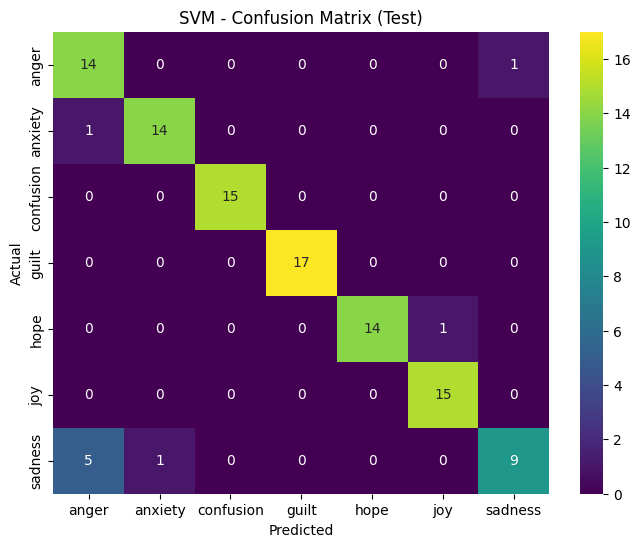

In [ ]:
emotion_model, emotion_encoder = train_svm_classifier("refined_emotion_dataset.csv")

The final accuracy of my SVM model using the "all-mpnet-base-v2" embeddings is 92% on the test set.

In [ ]:
import joblib

# Save model
joblib.dump(emotion_model, "emotion_model.pkl")

# Save label encoder
joblib.dump(emotion_encoder, "emotion_encoder.pkl")

# Download
from google.colab import files

files.download("emotion_model.pkl")
files.download("emotion_encoder.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>